<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
:پروژه ی هفتم
</font>
</h1>
<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
Max Pooling and Convolution with Neurons
</h1>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
  عرشیا ربیعی 
    
</font> 
</p>
<p dir=rtl style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4 color="orange">
۶۱۰۳۹۸۱۲۵ 
    
</font> 
</p>

In [2]:
from pymonntorch import *
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [3]:
settings = {'device' : 'cpu' , 'def_type' : torch.float32 }
settings = {'device' : 'cpu' , 'def_type' : torch.float32}

torch.manual_seed(73)
N = 100
REGULAR_SPIKE = {'a' : 0.02 , 'b' : 0.2 , 'c' : -65 , 'd' : 8}
IB = {'a' : 0.02 , 'b' : 0.2 , 'c' : -55 , 'd' : 4}
CHATTERING = {'a' : 0.02 , 'b' : 0.2 , 'c' : -50 , 'd' : 2}
LOW_THRESHOLD_SPIKING = {'a' : 0.02 , 'b' : 0.25 , 'c' : -65 , 'd' : 2}
FAST_SPIKING = {'a' : 0.1 , 'b' : 0.2 , 'c' : -65 , 'd' : 2}
PARAMETER_CHOOSE = REGULAR_SPIKE

np.random.seed(72)
SIGMA1 = 5
SIGMA2 = 9
KERNEL_SIZE = (3,3)
MEAN = 128

TIME = 500
INFINITY = 1e9

In [4]:
class Time(Behavior):
    def initialize(self,network):
        network.dt = self.parameter('dt' , 1)
        network.passed = 0
    def forward(self , network):
        network.passed += network.dt

In [5]:
class Dendrite(Behavior):
    def forward(self, n):
        for syn in n.afferent_synapses['Pooling']:
            n.I += syn.I

In [6]:
class InputSynapse(Behavior):
    def initialize(self,syn):
        self.density = self.parameter('den' , 1)
        self.W = syn.matrix('uniform' ,density = self.density)
        self.coef = self.parameter('coef' , None)
    def forward(self , syn):
        pre_spike = syn.src.spike
        syn.I = torch.sum(self.W.t()[pre_spike],axis = 0)* self.coef

In [7]:
class Izhikevich_Input(Behavior):
    def initialize(self , n):
        self.second_layer = self.parameter('layer2' , False , required=False)
        n.ttfs = self.parameter('ttfs' , None , required=False)
        n.I = np.zeros(n.size)
        if self.second_layer:
            n.I = np.zeros(n.size)
        
    def forward(self , n):
        if not self.second_layer:
            n.I= np.zeros(n.size)
            ttfs_curr_index = n.network.passed
            n.ttfs_curr = n.ttfs[ttfs_curr_index].copy()
            flat_curr_ttfs = n.ttfs_curr.reshape(n.ttfs.shape[1] * n.ttfs.shape[2]).copy()
            while flat_curr_ttfs.max() != 0:
                n.I[flat_curr_ttfs.argmax()] = 50
                flat_curr_ttfs[flat_curr_ttfs.argmax()] = 0
        else:
            n.I = np.zeros(n.size)

In [8]:
class Izhikevich(Behavior):
    def initialize(self , n):
        self.a = self.parameter('a' , None , required=True)
        self.b = self.parameter('b' , None , required=True)
        self.c = self.parameter('c' , None , required=True)
        self.d = self.parameter('d' , None , required=True)
        self.I_flag = self.parameter('I_flag' , False ,required=False)
        self.threshold = self.parameter('threshold' , 30)
        n.v = n.vector('uniform') * -70
        n.u = n.vector('uniform') * -15
        n.spike = n.v > self.threshold

    def _fire(self , n):
        self._spike(n)
        n.v[n.spike] = self.c
        n.u[n.spike] += self.d
    def _dv_du(self,n):
        self.dv = 0.04* (n.v**2) + 5*n.v + 140 - n.u + n.I
        self.du = self.a*(self.b * n.v - n.u)
    def _spike(self , n):
        n.spike = n.v > self.threshold
    def forward(self , n):
        self._dv_du(n)
        n.v += self.dv * n.network.dt
        n.u += self.du * n.network.dt
        self._fire(n)

In [9]:
class Pooling(Behavior):
    def initialize(self , syn):
        self.kernel_size = self.parameter('size' , (2,2) , required=False)
        self.stride = self.parameter('stride' , 2 , required=False)
    def forward(self , syn):
        ttfs_dst_curr = np.zeros((64 , 64))
        for i in range(0 , ttfs_dst_curr.shape[0] , self.stride):
            for j in range(0 , ttfs_dst_curr.shape[1] , self.stride):
                ttfs_dst_curr[i//self.stride , j//self.stride] = syn.src.ttfs_curr[i: i+self.stride , j : j+self.stride].max()
        syn.I = ttfs_dst_curr.flatten() * 50

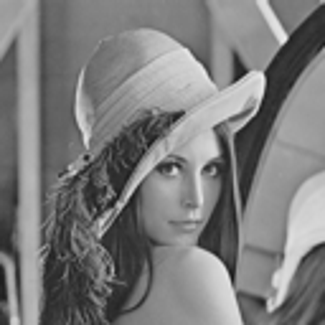

In [10]:
image = Image.open("Lena.PNG")
image = image.convert("L")
image = image.resize((128,128))
image.resize((325 , 325))

In [10]:
img_gray = np.array(image)
img_gray

array([[162, 161, 161, ..., 120, 163, 163],
       [160, 159, 159, ..., 126, 129, 101],
       [157, 156, 157, ..., 103,  56,  43],
       ...,
       [ 53,  55,  59, ...,  57,  53,  62],
       [ 51,  53,  54, ...,  58,  70,  88],
       [ 48,  51,  50, ...,  68,  91, 102]], dtype=uint8)

In [11]:
class Dog:
    def __init__(self , sigma1 , sigma2 , kernel_size , stride=1):
        self.s1 = sigma1
        self.s2 = sigma2
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = (self.kernel_size[0] - 1)//2
    def dog_filter(self):
        (y ,x) = np.meshgrid(np.arange(int(-self.kernel_size[0]/2) , (self.kernel_size[0])//2 + 1) , np.arange(int(-self.kernel_size[1]/2) ,(self.kernel_size[1])//2 + 1))
        xy = -0.5 * ((x**2 + y ** 2))
        return (np.exp(xy/self.s1 **2)/self.s1 - np.exp(xy/self.s2**2)/self.s2) / np.sqrt(2 * np.pi)
    def get_filt(self , oncenter):
        if oncenter:
            filt = self.dog_filter()
        else:
            filt = -self.dog_filter()
        return filt
    def dog_apply(self , img , oncenter = True):
        filt = self.get_filt(oncenter)
        plt.imshow(filt ,cmap='gray');
        result = np.zeros(img.shape)
        pad_img = np.pad(img , pad_width=self.pad)
        for i in range(0 , len(pad_img) - self.kernel_size[0]+1 , self.stride):
            for j in range(0 , len(pad_img) - self.kernel_size[1]+1 , self.stride):
                result[i , j] = np.sum( (pad_img[i: i + self.kernel_size[0], j : j + self.kernel_size[1]]) * filt)
        result -= result.min()
        result /= result.max()
        result *= 255
        return result
    def ttfs(self, img):
        ttfs = []
        img_copy = img.copy()
        i = 0
        ttfs.append(np.zeros((img_copy.shape[0] , img_copy.shape[1])))
        while img_copy.max() != -INFINITY:
            tmp_max = img_copy.max()
            flat_max_index = img_copy.argmax()
            j = flat_max_index // img_copy.shape[1]
            k = flat_max_index % img_copy.shape[0]
            ttfs[i][j , k] = 1
            img_copy[j,k] = -INFINITY
            if tmp_max != img_copy.max():
                ttfs.append(np.zeros((img_copy.shape[0] , img_copy.shape[1])))
                i += 1
        ttfs = np.array(ttfs)
        return ttfs
    def scatter_array(self , ttfs):
        ttfs_reshape = ttfs.reshape(ttfs.shape[0] , ttfs.shape[1] * ttfs.shape[2])
        x = []
        y = []
        for i in range(ttfs_reshape.shape[0]):
            for j in range(ttfs_reshape.shape[1]):
                if ttfs_reshape[i , j] == 1:
                    x.append(i)
                    y.append(j)
        return x , y

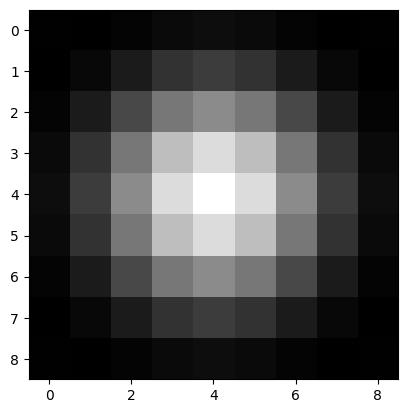

In [12]:
dog = Dog(2 , 5 , (9,9))
on_center = dog.dog_apply(img_gray)

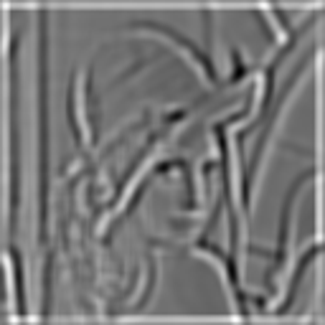

In [13]:
Image.fromarray(np.array(on_center).astype(np.uint8)).resize((325 ,325))

In [14]:
ttfs_on_center = dog.ttfs(on_center.astype(int))
ttfs_on_center.shape

(235, 128, 128)

In [15]:
net = Network(settings=settings , behavior={
    11 : Time(dt = 1),
})

In [16]:
layer1 = NeuronGroup(net= net ,tag='layer1' ,  size= img_gray.shape[0] * img_gray.shape[1]  , behavior={
    2 : Izhikevich_Input(ttfs = ttfs_on_center , layer2 = False),
    4 : Izhikevich(**PARAMETER_CHOOSE),
    8 : Recorder(tag='input_layer' , variables = ['v' , 'u']),
    9 : EventRecorder(tag='input_layer_event' , variables=['spike'])
})

In [17]:
layer2 = NeuronGroup(net= net ,tag='layer2', size= int(img_gray.shape[0]//2 * img_gray.shape[1]//2)  , behavior={
    2 : Izhikevich_Input(layer2=True),
    6 : Dendrite(),
#     5 : Recorder(tag='exc_rec2' , variables = ['I']),
    7 : Izhikevich(**PARAMETER_CHOOSE ,I_flag = True, inp = True),
    8 : Recorder(tag='inputLayer' , variables = ['v' , 'u']),
    9 : EventRecorder(tag='input_layer_event' , variables=['spike'])
})

In [18]:
syn = SynapseGroup(net=net , src=layer1 , dst=layer2 ,tag = 'Pooling', behavior={
    5 : Pooling()
})

In [19]:
net.initialize()
net.simulate_iterations(ttfs_on_center.shape[0])

Network['Network'](Neurons: tensor(20480)|2 groups, Synapses: tensor(67108864)|1 groups){11:Time(dt=1,)}
NeuronGroup['layer1', 'NeuronGroup', 'ng'](16384){2:Izhikevich_Input(ttfs=[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0

3656.8543910980225

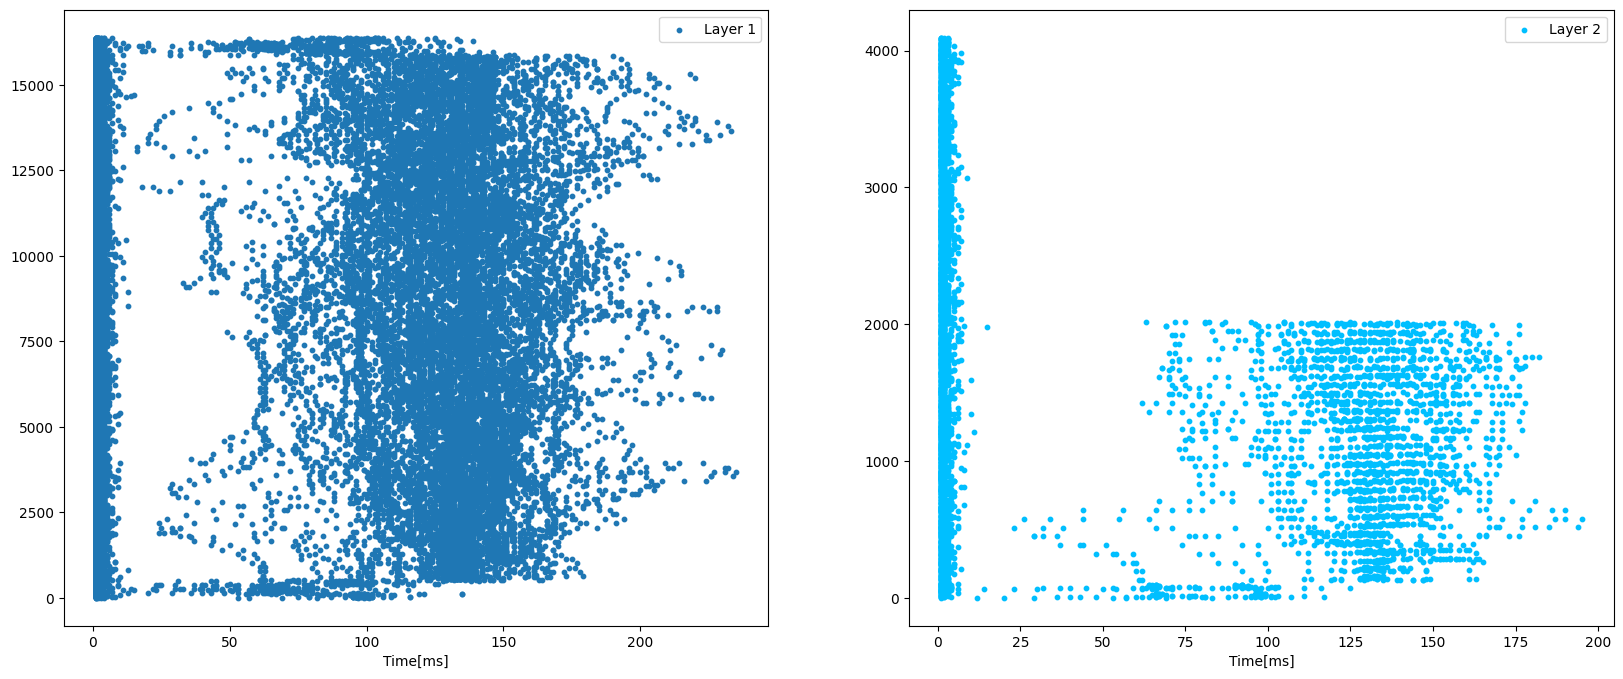

In [20]:
fig , ax = plt.subplots(1,2 , figsize=(20, 8))
ax[0].scatter(net["layer1",0]["spike",0][:,0],net["layer1",0]["spike",0][:,1], s = 10 , label = 'Layer 1')
ax[0].set_xlabel('Time[ms]')
ax[0].legend()


ax[1].scatter(net["layer2",0]["spike",0][:,0],net["layer2",0]["spike",0][:,1],color = 'deepskyblue' , s = 10 , label = 'Layer 2')
ax[1].set_xlabel('Time[ms]')
ax[1].legend();